In [2]:
# This is a fix for vscode, because it doesn't like my
# julia docstrings for whatever reason, and throws a `Katex` error.
using Markdown
Base.show(io::IO, ::MIME"text/latex", md::Markdown.MD) = plain(io, md)

In [3]:
using BenchmarkTools;
using CUDA
using Base: @doc
using Revise
using Random: shuffle, randperm

push!(LOAD_PATH, "../../src");
using Pose2D
using Geometry: Segment
using MyUtils
using Raycaster
using SensorDistributions;

In [4]:
using Colors, Plots, Images;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using Fmt: @f_str, format # Python-style f-strings
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: ProductDistribution

const diagnormal = broadcasted_normal

mvuniform = ProductDistribution(uniform);

## Load Environment

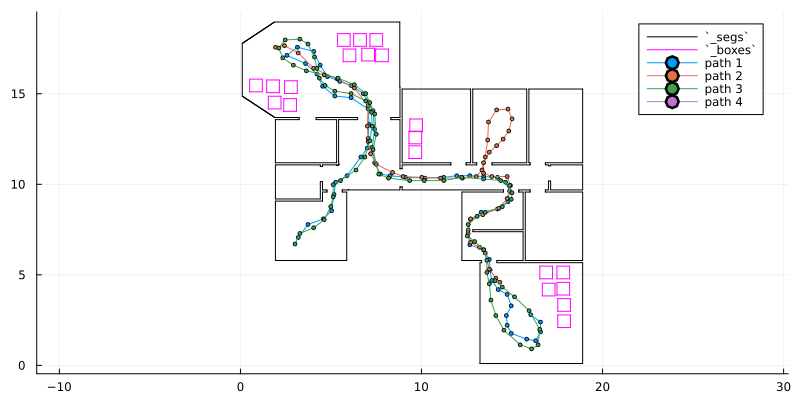

In [5]:
include("../../src/house_expo_utils.jl");

fname = "../data/task_inputs/test_env_2.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=2, c=col[i], label="path $i")
end
mypl

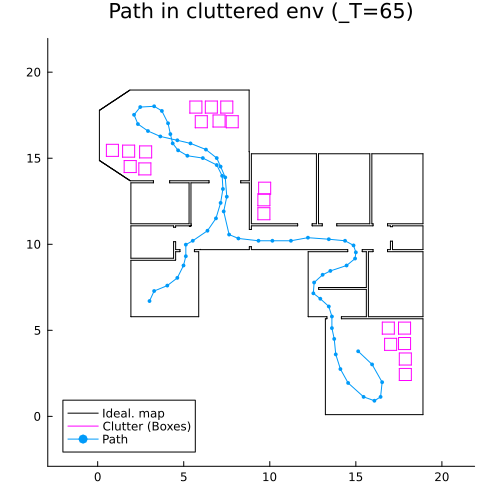

In [6]:
_ps, _us = unpack_path(_paths[3])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

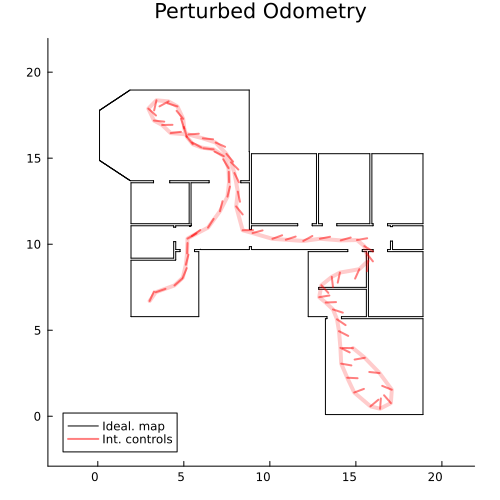

In [7]:
#nbx
x_noise  = 0.1
hd_noise = 5/360*2π
us_noisy = perturb.(_us, x_noise, hd_noise);

rel_ps = [p+u for (p,u) in zip(_ps[1:end-1],us_noisy)];
ps_noisy = [_ps[1]]
for u in us_noisy
    push!(ps_noisy, ps_noisy[end] + u)
end

# -----------------
env_plt = plot(
    size=(500,500), aspect_ratio=:equal, title="Perturbed Odometry", axis=true, grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!([p.x for p in ps_noisy], c=:red, label=nothing, alpha=0.2, linewidth=4)

plot!(ps_noisy[[1]],     c=:red,  r=.6, label="Int. controls", alpha=0.5, linewidth=2)
plot!(ps_noisy[2:end], c=:red,  r=.6,  label=nothing,  alpha=0.5, linewidth=2)
env_plt

In [8]:
#nbx
"""
    zs, _as, ys = create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    
Return depth measurements `zs` and the angles `_as` along which the measuremnts were taken, 
and their 2D point cloud version `ys` for a given set of poses `ps` and a map `segs` of line
segments.

Example:
```julia
    _obs_noise = 0.1
    _fov       = 2π
    _num_a     = 361
    _zs, _as, _ys   = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)
```
"""
function create_observations(ps::Vector{Pose}, segs, fov, num_a, obs_noise=0.0)
    segs = stack(Vector.(segs));
    ps   = stack(Vector.(ps));

    zs  = cast(ps, segs; fov=fov, num_a=num_a)
    zs += _obs_noise * randn(size(zs))
    zs  = unstack(zs);

    as  = [range(-fov/2, fov/2, _num_a)...];
    ys  = [polar_inv(z,as) for z in zs]
    return zs, as, ys
end

create_observations

In [9]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

# -------------
println("Created a few new variables:\n")
summarize_vars(:(_obs_noise, _fov, _as, _zs, _ys))
println("")

Created a few new variables:

_obs_noise Float64
_fov       Float64
_as        Vector{Float64}
_zs        Vector{Vector{Float64}}
_ys        Vector{Vector{Vector{Float64}}}



[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/tmp.gif")
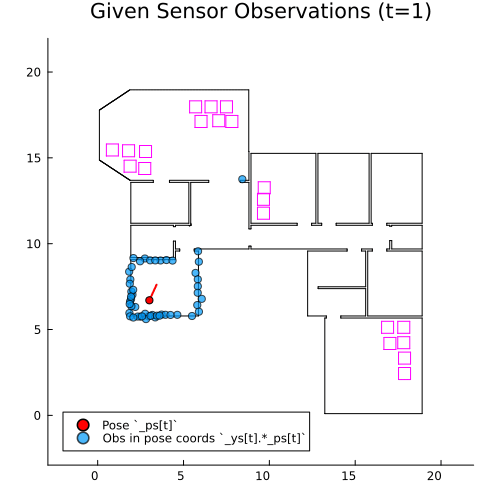

In [10]:
# -----------------------
ani = Animation()
for t=1:1:_T
    p = _ps[t]
    y = _ys[t]

    agent_plt = plot(
        size=(500,500), aspect_ratio=:equal, title="Given Sensor Observations (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)
    plot!([p], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([p.x], c=:red, label="Pose `_ps[t]`")
    scatter!(shuffle(y[1:2:end]).*p, c=col[1], markersize=4, alpha=.7, markerstrokewidth=1, label="Obs in pose coords `_ys[t].*_ps[t]`")
    frame(ani, agent_plt)
end
# gif(ani, "_imgs/loc_data_gen.gif", fps=2) # gif(ani, fname, fps=10)
gif(ani, fps=4)

In [11]:
include("../../src/grid_proposals.jl")

function eval_pose_vectors2(
    vs   :: Array{Vector{Float64}},
    z    :: Vector{Float64},
    segs :: Vector{Segment},
    fov, num_a, w::Int,
    sig, outlier,
    zmax::Float64=50.0; sorted=false)

    # Compute sensor measurements and
    # Gaussian mixture components
    # p_  = CuArray(Vector(p))
    # ps_ = reshape(p_, 1, 3)

    ps   = stack(vs[:])
    segs = stack(Vector.(segs))
    as   = create_angles(fov, num_a)

    if _cuda[]
        ps   = CuArray(ps)
        z    = CuArray(z)
        segs = CuArray(segs)
        as   = CuArray(as)
        sig   = CuArray(sig)
        outlier   = CuArray(outlier)
    end

    z = clamp.(z, 0.0, zmax)

    zs = cast(ps, segs; fov=fov, num_a=num_a, zmax=zmax)
    ỹ, d̃ = get_1d_mixture_components(zs, as, w);

    # Evaluate the the observations with respect to the
    # different Gaussian mixtures computed above
    log_ps,_,outl = depthdist_logpdf(z, ỹ, d̃, sig, outlier, zmax;
                        scale_noise=false, return_pointwise=false, return_outliermap=true);

    # Move everyting back to CPU if is not already there
    log_ps = Array(log_ps)

    # Sort by log prob
    # and return
    # if sorted
    # perm   = sortperm(log_ps)
    # log_ps = log_ps[perm]
    # vs     = vs[:][perm]
    # end

    return log_ps, outl
end;

(10, 10, 10)
 52.783348 seconds (100.17 M allocations: 5.113 GiB, 3.87% gc time, 75.53% compilation time)
(1000, 10, 10)(1000, 100, 10, 10)
CartesianIndex(355, 1, 7)
maximum log prob: -64.98908068764696


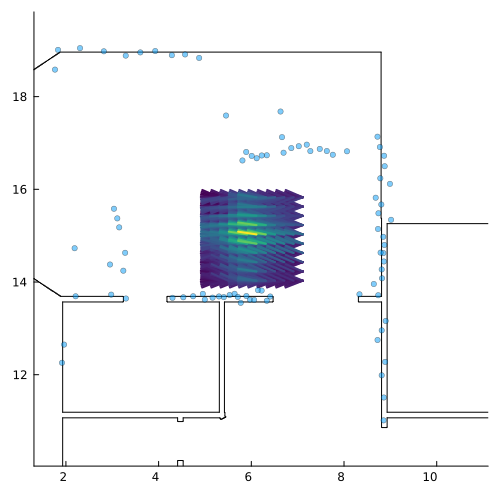

In [12]:
t = 15
z = _zs[t]
p0 = _ps[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))

v0 = Vector(p0)
grid_args = (
    k = [10, 10, 10],
    r = [.2, .2, 5/180*π],
)


vs, = vector_grid(v0, grid_args...)

println(size(vs))


w       = 10
sig     = range(0.1, 1., 10)
outlier = range(0.01, 0.4, 10)
zmax    = 25.

@time log_ps, outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

println(size(log_ps), size(outl))
i = argmax(log_ps)
println(i)
x = polar_inv(z, _as)

println("maximum log prob: ", maximum(log_ps))
vals = log_ps[:,i[2],i[3]]
perm = sortperm(vals)
vals = vals[perm]

# -----------------------------
delta = 4
mypl = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
    xlim=(vs[1][1]-delta, vs[end][1]+delta),
    ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)
cs = cgrad(:viridis)[peak_to_peak(vals)]
plot!(Pose.(vs[perm]), cs, r=.4, linewidth=2)
scatter!(x .* Pose(vs[i[1]]), markerstrokewidth=0.5, c=col[1], alpha=0.5, markersize=3)
display(mypl)


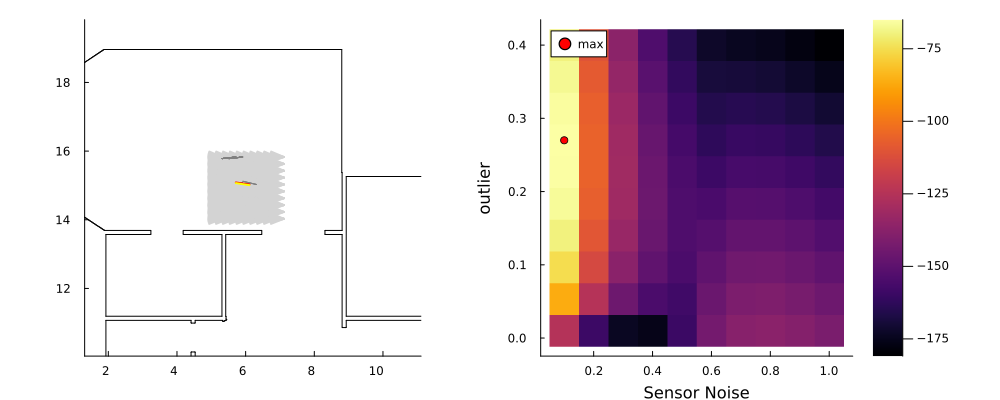

In [13]:
m = dropdims(maximum(log_ps, dims=1), dims=1)
I = dropdims(argmax(log_ps, dims=1), dims=1)
imax = argmax(log_ps)

# -----------------------------
plot_1 = plot(size=(600,400), title="",
    grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
)
heatmap!(sig, outlier, m')
scatter!([sig[imax[2]]],outlier[[imax[3]]], label="max", c=:red)

# -----------------------------
plot_2 = plot(size=(500,500), legend=nothing, aspect_ratio=:equal,  grid=false, showaxis = true,
xlim=(vs[1][1]-delta, vs[end][1]+delta),
ylim=(vs[1][2]-delta, vs[end][2]+delta) 
)
plot!(_segs, c=:black)

plot!(Pose.(vs[:]), c=:lightgray, r=.4, linewidth=2)
for i in I
    plot!(Pose(vs[i[1]]), r=.4, c=:gray, linewidth=1)
end
plot!(Pose(vs[imax[1]]), r=.4, c=:red, linewidth=2)
plot!(_ps[t], r=.4, c=:yellow, linewidth=2)

# -----------------------------
plot(plot_2, plot_1, layout=(1,2), size=(1000,400), margin=3Plots.mm)


  0.032482 seconds (2.96 k allocations: 2.234 MiB)
  0.035126 seconds (3.05 k allocations: 2.242 MiB)
  0.206990 seconds (28.40 k allocations: 3.558 MiB, 27.15% gc time, 53.89% compilation time)
  0.030026 seconds (3.05 k allocations: 2.243 MiB)
  0.064656 seconds (3.37 k allocations: 2.253 MiB, 49.97% gc time)
  0.029769 seconds (3.05 k allocations: 2.242 MiB)
  0.029899 seconds (3.05 k allocations: 2.242 MiB)
  0.062790 seconds (3.37 k allocations: 2.252 MiB, 46.89% gc time)
  0.029775 seconds (3.05 k allocations: 2.242 MiB)
  0.053417 seconds (3.38 k allocations: 2.253 MiB, 39.54% gc time)
  0.029812 seconds (3.05 k allocations: 2.243 MiB)
  0.046874 seconds (3.37 k allocations: 2.253 MiB, 31.15% gc time)
  0.029800 seconds (3.05 k allocations: 2.242 MiB)
  0.029765 seconds (3.05 k allocations: 2.243 MiB)
  0.050060 seconds (3.37 k allocations: 2.252 MiB, 34.31% gc time)
  0.029731 seconds (3.05 k allocations: 2.242 MiB)
  0.047150 seconds (3.38 k allocations: 2.254 MiB, 31.77% gc t

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/hierarchical_sensor.gif")
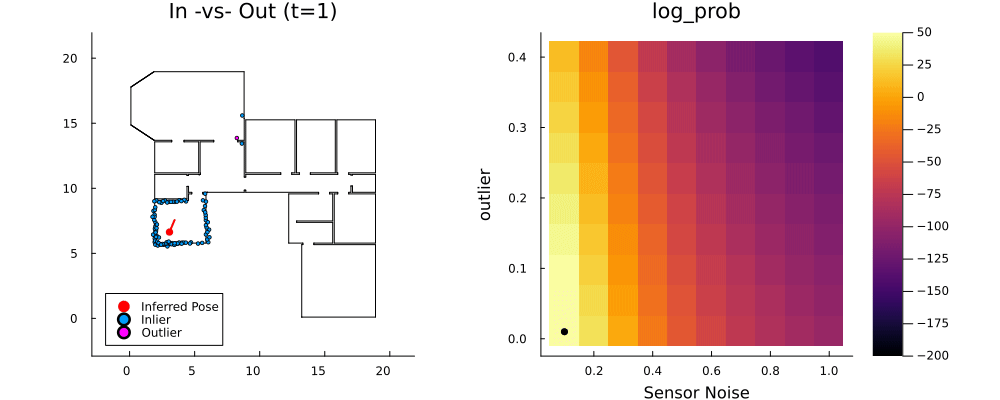

In [14]:

q = _ps[1] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:30

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)
    grid_args = (
        k = [9, 9, 31],
        r = [.2, .2, 1/180*π],
    )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 10)
    outlier = range(0.01, 0.4, 10)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")
    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-200,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label=nothing, c=:black)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 7/180*π))
end
gif(ani, "_imgs/hierarchical_sensor.gif", fps=5)
# gif(ani, fps=5)

# Version 2

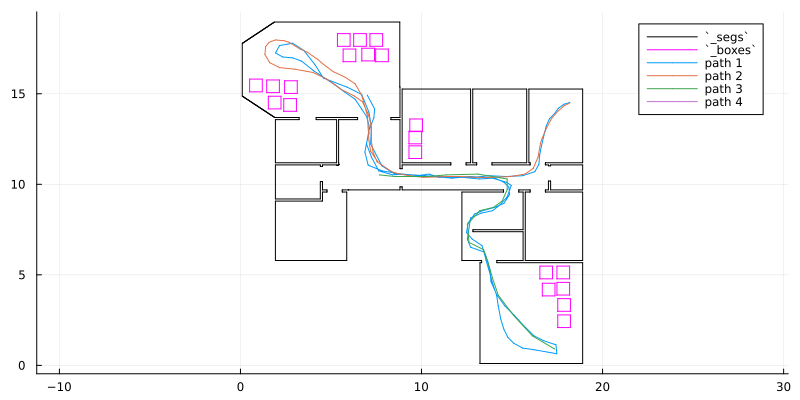

In [15]:
fname = "../data/task_inputs/test_env_3.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=0, c=col[i], label="path $i")
end
mypl

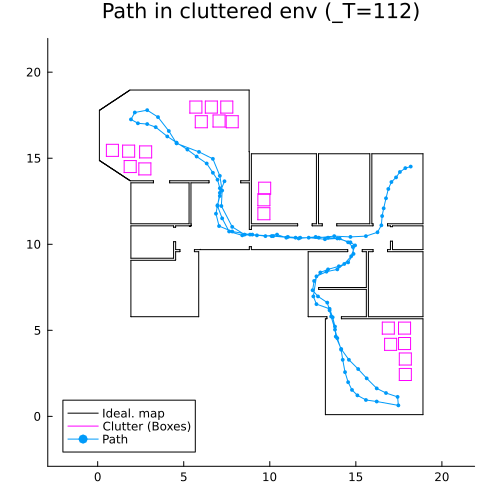

In [16]:
_ps, _us = unpack_path(_paths[1])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [17]:
#nbx
_obs_noise = 0.2
_fov       = 2π
_num_a     = 200

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

([[0.8952609136605187, 0.6649760288002613, 0.6331802956800158, 0.8178404883531084, 0.36182656673468977, 0.5633853186906825, 0.8924796403641261, 0.7665391515361542, 1.2212035452364074, 0.874750304529436  …  0.6943358321777717, 0.6210134687750772, 0.47355357913127605, 0.8455270757005483, 0.21849246808901668, 0.9572259796285224, 0.37742429294590496, 0.8459155030923764, 0.37259209431025375, 0.6480460467536102], [1.5740572392424483, 1.0991013205447029, 1.5846145424061286, 1.4049722550545827, 1.3036106167865278, 1.0644962959384565, 0.6328165324820946, 1.2088097456375704, 1.0260162668036907, 1.3001798149302228  …  0.9632941142430012, 1.0854882646348358, 1.173523224919862, 1.490775848308145, 1.382731770701036, 1.306077421570337, 0.9649263456340835, 1.4311711474694238, 1.210542583622329, 1.3642681980824873], [1.1776392016039263, 0.9023873603616821, 1.1221754521918412, 0.9931345645644449, 1.2542132382132511, 1.2908372017549719, 1.2451890518625726, 1.4519766605012823, 1.1601141115646216, 0.903429

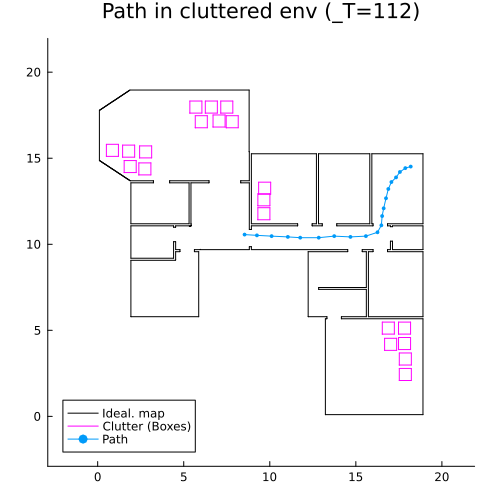

In [18]:
ts1 = 1:20

_ps, _us = unpack_path(_paths[1])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps[ts1]), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

  1.315105 seconds (1.53 M allocations: 79.146 MiB, 12.24% compilation time)
  0.004297 seconds (2.81 k allocations: 326.250 KiB)
  0.004264 seconds (2.81 k allocations: 326.211 KiB)
  0.004271 seconds (2.82 k allocations: 327.070 KiB)
  0.004270 seconds (2.81 k allocations: 326.211 KiB)
  0.004229 seconds (2.81 k allocations: 326.211 KiB)
  0.004233 seconds (2.81 k allocations: 326.211 KiB)
  0.004277 seconds (2.81 k allocations: 326.211 KiB)
  0.004457 seconds (2.81 k allocations: 326.211 KiB)
  0.004237 seconds (2.82 k allocations: 327.070 KiB)
  0.004340 seconds (2.81 k allocations: 326.508 KiB)
  0.004315 seconds (2.82 k allocations: 326.258 KiB)
  0.004293 seconds (2.81 k allocations: 326.211 KiB)
  0.004304 seconds (2.81 k allocations: 326.211 KiB)
  0.004284 seconds (2.81 k allocations: 326.211 KiB)
  0.004274 seconds (2.82 k allocations: 327.070 KiB)
  0.004301 seconds (2.81 k allocations: 326.211 KiB)
  0.004315 seconds (2.81 k allocations: 326.211 KiB)
  0.004251 seconds (2.

[ Info: Saved animation to /home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/kidnap_1.gif


Plots.AnimatedGif("/home/ubuntu/workspace/probabilistic-slam-in-gen/notebooks/v2/_imgs/kidnap_1.gif")
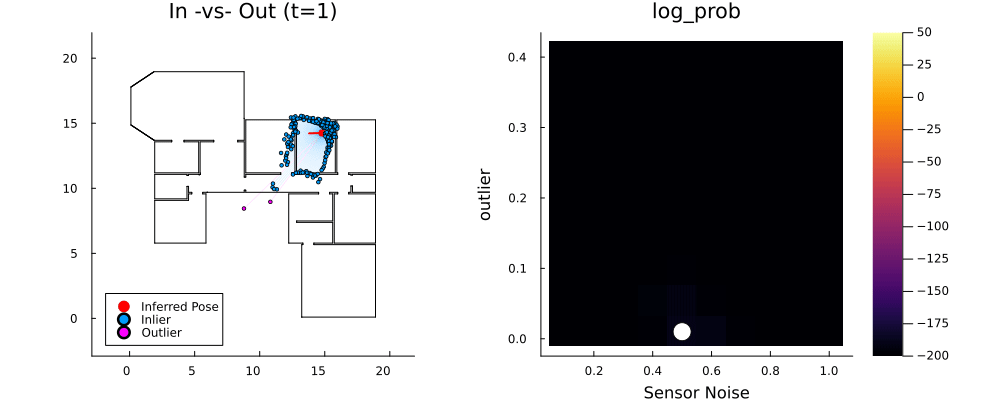

In [19]:

q = _ps[1] + Control([-4;0], 0) + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()
for t=1:20

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)

    grid_args = (
        k = [5, 5, 5],
        r = [.2, .2, 2/180*π],
    )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 10)
    outlier = range(0.01, 0.4, 10)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    # -----------------------------
    agent_plot = plot(
        size=(500,500), aspect_ratio=:equal, title="In -vs- Out (t=$t)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    # for j=1:5:length(y)
    for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    end
    for yy in y[outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)
    plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
    scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=1., markerstrokewidth=1, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=1., markerstrokewidth=1, label="Outlier")

    # -----------------------------
    heat_plot = plot(size=(600,400), title="log_prob",
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm
    )
    heatmap!(sig, outlier, m', clim=(-200,50))
    scatter!([sig[imax[2]]],outlier[[imax[3]]], label=nothing, markersize=10, c=:white)
    # -----------------------------
    frame(ani, plot(agent_plot, heat_plot, layout=(1,2), size=(1000,400), margin=3Plots.mm))


    q = q + _us[t] + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 7/180*π))
end
gif(ani, "_imgs/kidnap_1.gif", fps=2)
# gif(ani, fps=5)

# Version 3

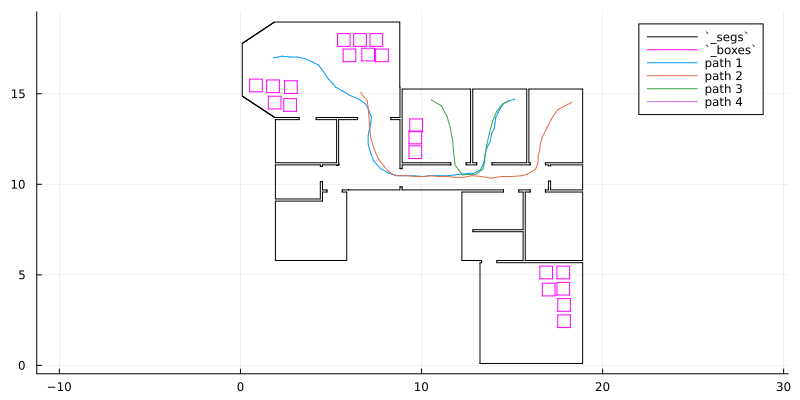

In [20]:
fname = "../data/task_inputs/test_env_4.json"
_segs, _boxes, _paths = load_env(fname)
_bb = bounding_box(_segs)

# ----------------
mypl = plot(size=(800, 400), aspect_ratio=:equal)
plot!(_segs, c=:black, label="`_segs`")
plot!(_boxes, c=:magenta, label="`_boxes`")
for (i,xs) in enumerate(_paths)
    plot!(xs, marker=:o, markersize=0, c=col[i], label="path $i")
end
mypl

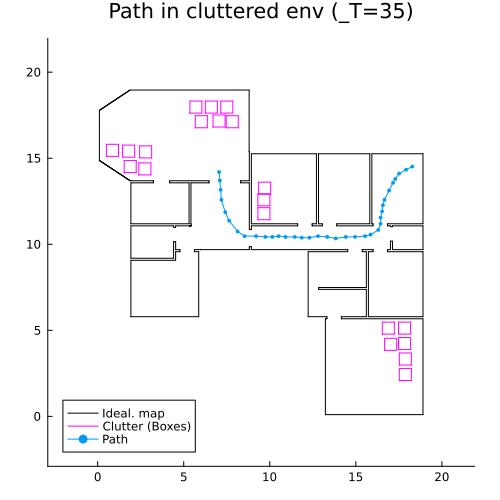

In [21]:
_ps, _us = unpack_path(_paths[2])
_T = length(_ps)

# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl

In [22]:
#nbx
_obs_noise = 0.1
_fov       = 2π
_num_a     = 100

# Todo: This should be computed in the data file, but 
#       it also depens on `fov` so ...whatever
_zs, _as, _ys = create_observations(_ps, vcat(_segs, _boxes), _fov, _num_a, _obs_noise)

([[0.631840127181931, 0.7271116475192492, 0.8942228892389673, 0.9566633993734621, 0.9237378446821386, 1.0726578392486747, 0.888145927185753, 0.9495871773738936, 1.0285534940997965, 0.9297743762083044  …  0.6897758421629432, 0.6637296262686013, 0.6952379863850322, 0.43071738089196787, 0.5918289327856888, 0.6038419304620612, 0.5607759136819567, 0.7456638720393327, 0.7335270637524793, 0.7031710782025987], [1.146933417203465, 1.1550197571612804, 1.0765337628442548, 1.2457662342335694, 1.391069979974663, 1.2098662222082954, 1.1954847603497674, 0.9477247290436409, 0.8339055278152164, 0.8661656752791921  …  0.8679609564661235, 0.9118801641212142, 1.0069633247903897, 0.984272462659339, 0.7706490564647646, 1.0399502365326496, 0.9274342904394228, 1.1355094363842515, 1.0888258973877245, 1.22868474176008], [1.5446069677700125, 1.4257566999321332, 1.3148283296091636, 1.1642747915344744, 1.243890001606381, 1.0975037281481375, 1.1261941285499506, 1.216573865208646, 1.1670415635839153, 0.9577546767108

In [1]:

q = _ps[1] + Control([-4;0], 0) + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 10/180*π))
qs = []
ani = Animation()

grid_args = (
    k = [21, 21, 21],
    r = [.1, .1, 2/180*π],
)

confused = false

t=1
# while t < 6
while t < _T
# for t=1:_T

    z = _zs[t]
    y = _ys[t]

    v0 = Vector(q)

    # grid_args = (
    #     k = [11, 11, 11],
    #     r = [.1, .1, 2/180*π],
    # )

    vs, = vector_grid(v0, grid_args...)

    w       = 10
    sig     = range(0.1, 1., 12)
    outlier = range(0.01, 0.4, 12)
    zmax    = 25.

    @time log_ps,outl = eval_pose_vectors2(vs, z, _segs, _fov, _num_a, w, sig, outlier, zmax; sorted=false)

    log_ps = Array(log_ps)
    outl = Array(outl)

    q = Pose(vs[argmax(log_ps)[1]])
    push!(qs, q)
    
    m = dropdims(maximum(log_ps, dims=1), dims=1)
    I = dropdims(argmax(log_ps, dims=1), dims=1)
    imax = argmax(log_ps)

    if sig[imax[2]] < 0.6 
        confused = false
    else 
        confused = true
    end

    # -----------------------------
    agent_plot1 = plot(
        size=(500,500), aspect_ratio=:equal, title="Internal Represenation", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )

    for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    end
    for yy in y[outl[imax[1],:,imax[2],imax[3]]]
        plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    # plot!(_boxes, c=:magenta, label=nothing)

    # plot!([q.x,_ps[t].x], c=:lightgray, alpha=.5, linewidth=3, label=nothing)
    # plot!([_ps[t]], c=:lightgray, r=1.0, linewidth=2, label=nothing)
    # scatter!([_ps[t].x], c=:lightgray,  markerstrokewidth=0, label="Actual Pose")
    if confused
        plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    else
        plot!([q], c=:black, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:black,  markerstrokewidth=0, label="Inferred Pose")
    end
    
    scatter!(shuffle(y[.!outl[imax[1],:,imax[2],imax[3]]]).*q, c=col[1], markersize=2, alpha=.5, markerstrokewidth=0, label="Inlier")
    scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=.5, markerstrokewidth=0, label="Outlier")



    # s =(sig[imax[2]] - sig[1])/sig[end] 
    # c = RGBA(1,0,0, s)
    # # c = cgrad(:berlin)[s] 
    # annotate!(10,20, text("NOISE!", 12, c, :left))

    # s = (outlier[imax[3]] - outlier[1])/outlier[end]
    # c = cgrad(:berlin)[s] 
    # c = RGBA(1,0,0, s)
    # annotate!(16,20, text("OUTLIERS!", 12, c, :left))
    # -----------------------------
    agent_plot2 = plot(
        size=(500,500), aspect_ratio=:equal, title="Actual Environment\n(with inferred Pose)", grid=false,
        xlim=(_bb[1][1]-3, _bb[2][1]+3),
        ylim=(_bb[1][2]-3, _bb[2][2]+3),
        legend=:bottomleft,
    )
    # for j=1:5:length(y)
    # for yy in y[.!outl[imax[1],:,imax[2],imax[3]]]
    #     plot!([zeros(2), yy].*q, c=col[1], alpha=0.1, label=nothing)
    # end
    # for yy in y[outl[imax[1],:,imax[2],imax[3]]]
    #     plot!([zeros(2), yy].*q, c=:magenta, alpha=0.1, label=nothing)
    # end

    for yy in y
        plot!([zeros(2), yy].*_ps[t], c=:lightgray, alpha=0.4, label=nothing)
    end

    plot!(_segs, c=:black, linewidth=1, label=nothing)
    plot!(_boxes, c=:magenta, label=nothing)


    plot!([q.x,_ps[t].x], c=:gray, alpha=.5, linewidth=3, label=nothing)
    plot!([_ps[t]], c=:gray, r=1.0, linewidth=2, label=nothing)
    scatter!([_ps[t].x], c=:gray,  markerstrokewidth=0, label="Actual Pose")
    scatter!(shuffle(y).*_ps[t], c=:black, markersize=2, alpha=.4, markerstrokewidth=0, label="True Obs")


    if confused
        plot!([q], c=:red, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:red,  markerstrokewidth=0, label="Inferred Pose")
    else
        plot!([q], c=:black, r=1.0, linewidth=2, label=nothing)
        scatter!([q.x], c=:black,  markerstrokewidth=0, label="Inferred Pose")
    end
    

    
    # scatter!(shuffle(y[outl[imax[1],:,imax[2],imax[3]]]).*q, c=:magenta, markersize=2, alpha=.5, markerstrokewidth=0, label="Outlier")



    s =(sig[imax[2]] - sig[1])/sig[end] 
    c = RGBA(1,0,0, s)
    # c = cgrad(:berlin)[s] 
    annotate!(10,20, text("NOISE!", 12, c, :left))



    # s = (outlier[imax[3]] - outlier[1])/outlier[end]
    # c = cgrad(:berlin)[s] 
    # c = RGBA(1,0,0, s)
    # annotate!(16,20, text("OUTLIERS!", 12, c, :left))


    # -----------------------------
    heat_plot = plot(size=(400,400), title="LH", aspect_ratio=:equal, legend_position=:bottomleft, legend_font_size=6,
        grid=false, xlabel="Sensor Noise", ylabel="outlier", right_margin = 10Plots.mm, bottom_margin = 10Plots.mm,
    )
    heatmap!(sig, outlier, m') #, clim=(-250,10))
    scatter!([sig[imax[2]]],[outlier[imax[3]]], label="Max", markersize=2, marker=:o, c=:black)
    plot!([[0.6,-0.1],[0.6,0.5]], c=:red, linewidth=3, label=" Confusion threshold"   )
    # -----------------------------

    if t > 2
        frame(ani, plot(agent_plot2,agent_plot1, heat_plot, layout=(1,3), size=(1300,500), margin=5Plots.mm))
    end


    if !confused
        t+=1
        grid_args = (
            k = [21, 21, 21],
            r = [.1, .1, 2/180*π],
        )
        u = _us[t-1]
    else 
        grid_args = (
            k = [21, 21, 21],
            r = [.3, .3, 2/180*π],
        )
        u = Control([0;0], 0)
    end

    q = q + u + Control(diagnormal([0.;0.],[0.2;0.2]), normal(0, 5/180*π))
end
gif(ani, "_imgs/kidnap_wrong_room_3.gif", fps=4)
# gif(ani, fps=5)

LoadError: UndefVarError: _ps not defined

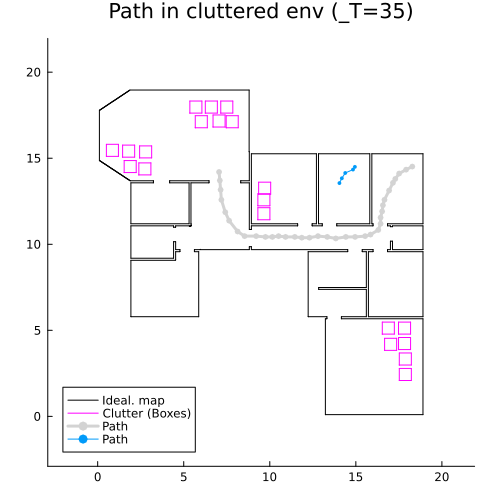

In [24]:
# -----------------------
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Path in cluttered env (_T=$_T)", grid=false,
    xlim=(_bb[1][1]-3, _bb[2][1]+3),
    ylim=(_bb[1][2]-3, _bb[2][2]+3),
    legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(Pose2D.position.(_ps), c=:lightgray, marker=:o, markersize=3, markerstrokewidth=0, linewidth=3, label="Path")
plot!(Pose2D.position.(qs), c=col[1], marker=:o, markersize=2, markerstrokewidth=0, linewidth=1, label="Path")
mypl